<a href="https://colab.research.google.com/github/bahador1/BahadorColabNotes/blob/main/Dr_Ji1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]

In [ ]:
train_dataset = MNIST('/kaggle/working', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('/kaggle/working', train=False, download=True, transform=transforms.ToTensor())

train_dataset, dev_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.83), int(len(train_dataset) * 0.17)])

In [ ]:
#define notebook constants

total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
total_dev_size = len(dev_dataset)

classes = 10
input_dim = 784

num_clients =3
rounds = 2
batch_size = 128
epochs_per_client = 3
learning_rate = 2e-2

In [ ]:
total_train_size, total_dev_size, total_test_size

(49800, 10200, 10000)

In [ ]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

In [ ]:
class FederatedNet(torch.nn.Module):    
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 4, 1)
        self.conv2 = torch.nn.Conv2d(4, 4, 1)
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(1024, 10)
        self.non_linearity = torch.nn.functional.relu
        self.track_layers = {'conv1': self.conv1,  'linear': self.linear}
    
    def forward(self, x_batch):
        out = self.conv1(x_batch)
        out = self.non_linearity(out)
        out = self.conv2(out)
        out = self.non_linearity(out)
        out = self.maxpool(out)
        out = self.flatten(out)
        out = self.linear(out)
        return out
    
    def get_track_layers(self):
        return self.track_layers
    
    def apply_parameters(self, parameters_dict):
        with torch.no_grad():
            for layer_name in parameters_dict:
                self.track_layers[layer_name].weight.data *= 0
                self.track_layers[layer_name].bias.data *= 0
                self.track_layers[layer_name].weight.data += parameters_dict[layer_name]['weight']
                self.track_layers[layer_name].bias.data += parameters_dict[layer_name]['bias']
    
    def get_parameters(self):
        parameters_dict = dict()
        for layer_name in self.track_layers:
            parameters_dict[layer_name] = {
                'weight': self.track_layers[layer_name].weight.data, 
                'bias': self.track_layers[layer_name].bias.data
            }
        return parameters_dict
    
    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            _, predictions = torch.max(outputs, dim=1)
            return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))
    
    def _process_batch(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)
    
    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history
    
    def evaluate(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

In [ ]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset
    
    def get_dataset_size(self):
        return len(self.dataset)
    
    def get_client_id(self):
        return self.client_id
    
    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.apply_parameters(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        print('{}: Loss = {}, Accuracy = {}'.format(self.client_id, round(train_history[-1][0], 4), round(train_history[-1][1], 4)))
        return net.get_parameters()

## Sieving 

In [ ]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import torchvision.datasets as datasets
from torchvision.datasets import CIFAR10


transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
testset = CIFAR10("./dataset", train=False, download=True, transform=transform)
targets = trainset.targets
target_indices = np.arange(len(targets))

# Split into train and validation
train_idx, val_idx = train_test_split(target_indices, train_size=0.8)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_dataset, dev_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.83), int(len(train_dataset) * 0.17)])

In [ ]:
# partitioning for plane dataset

# Get indices to keep from train split_plane
idx_to_keep = np.array(targets)[train_idx] ==0 
train_idx_plane = train_idx[idx_to_keep][:-1]
train_dataset_planeSubset = Subset(trainset, train_idx_plane)

# Split training set into 10 partitions to simulate the individual dataset
NUM_CLIENTS = 3
partition_size = len(train_dataset_planeSubset) // NUM_CLIENTS
lengths = [partition_size] * NUM_CLIENTS
train_datasets_plane = random_split(train_dataset_planeSubset, lengths, torch.Generator().manual_seed(42))

### dev/ test
# Get indices to keep from dev split_plane
idx_to_keep = np.array(targets)[val_idx] ==0 
val_idx_plane = val_idx[idx_to_keep][:-3]
val_dataset_planeSubset = Subset(trainset, val_idx_plane)

# Split training set into 10 partitions to simulate the individual dataset
NUM_CLIENTS = 3
partition_size = len(val_dataset_planeSubset) // NUM_CLIENTS
lengths = [partition_size] * NUM_CLIENTS
val_datasets_plane = random_split(val_dataset_planeSubset, lengths, torch.Generator().manual_seed(42))



ValueError: ignored

In [ ]:
# partitioning for car images

# for  using  car dataset
idx_to_keep = np.array(targets)[train_idx] == 1 
train_idx_car  = train_idx[idx_to_keep][:-2]
train_dataset_carSubset = Subset(trainset, train_idx_car)
# Split training set into 10 partitions to simulate the individual dataset
NUM_CLIENTS = 3
partition_size = len(train_dataset_carSubset) // NUM_CLIENTS
lengths = [partition_size] * NUM_CLIENTS
train_datasets_car = random_split(train_dataset_carSubset, lengths, torch.Generator().manual_seed(42))

###dev/ test
# partitioning for car images

# for  using  car dataset
idx_to_keep = np.array(targets)[val_idx] == 1 
val_idx_car  = val_idx[idx_to_keep]
val_dataset_carSubset = Subset(trainset, val_idx_car)
# Split training set into 10 partitions to simulate the individual dataset
NUM_CLIENTS = 3
partition_size = len(val_dataset_carSubset) // NUM_CLIENTS
lengths = [partition_size] * NUM_CLIENTS
val_datasets_car = random_split(val_dataset_carSubset, lengths, torch.Generator().manual_seed(42))

In [ ]:
client_datasets_bm1 = datasets_plane + datasets_car
training_data_all = 0
for i in client_datasets_bm1:
    training_data_all += len(i)
training_data_all

5046

In [ ]:
#concat all datset
train_dataset_concatenated= torch.utils.data.ConcatDataset([train_datasets_plane[0], train_datasets_plane[1], train_datasets_plane[2], train_datasets_car[0], train_datasets_car[1], train_datasets_car[2]])

In [ ]:
train_dataset_concatenated.__len__()

8034

In [ ]:
trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

train_dataset_inner, dev_dataset_inner = random_split(trainset, [int(len(trainset) * 0.83), int(len(trainset) * 0.17)])

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
dev_dataset_concatendate = torch.utils.data.ConcatDataset([val_datasets_plane[0], val_datasets_plane[1], val_datasets_plane[2], val_datasets_car[0], val_datasets_car[1], val_datasets_car[2]])

In [ ]:
dev_dataset_concatenated.__len__()

1959

In [ ]:
subset_indices = np.random.randint(0, 50000,8025) # select your indices here as a list
subset = torch.utils.data.Subset(trainset, subset_indices)
train_dataset = torch.utils.data.DataLoader(subset, shuffle = True)

In [ ]:
subset_indices = np.random.randint(0, 50000,1995) # select your indices here as a list
subset = torch.utils.data.Subset(trainset, subset_indices)
dev_dataset = torch.utils.data.DataLoader(subset, shuffle = True)

array([43152, 31792,  8352, ..., 19954, 42017, 45826])

In [ ]:
# Setup client
clients_plane = [Client('client_plane_' + str(i), client_datasets_bm1[i]) for i in range(num_clients)]

In [ ]:
clients_plane

In [ ]:
# Setup client
clients_car = [Client('client_car_' + str(i), datasets_car[i]) for i in range(num_clients)]

In [ ]:
clients = clients_plane + clients_car

In [ ]:
clients[3].client_id

'client_car_0'

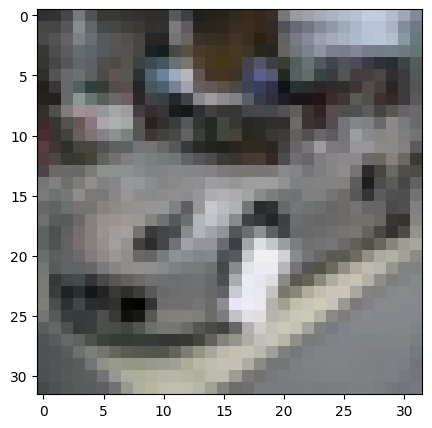

In [ ]:
#verifying
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(datasets_car[0])
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))

## continue

In [ ]:
# Setup client
examples_per_client = total_train_size // num_clients
client_datasets = random_split(train_dataset, [min(i + examples_per_client, 
           total_train_size) - i for i in range(0, total_train_size, examples_per_client)])
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

In [ ]:
# edit
empty_dict = dict()
clientlist = ['client_'+ str(i) for i in range(num_clients)]
empty_dict =empty_dict.fromkeys(clientlist)
empty_dict

{'client_0': None, 'client_1': None, 'client_2': None}

In [ ]:
# edit
roundlist = ['round_' + str(i+1) for i in range(2)]
roundlist

['round_1', 'round_2']

In [ ]:
#edit
all_info = dict()

In [ ]:
# Start server

global_net = to_device(FederatedNet(), device)
history = []
for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    curr_parameters = global_net.get_parameters()
    new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])
    for client in clients:
        client_parameters = client.train(curr_parameters)
        empty_dict[client.client_id] = client_parameters  # edit
        fraction = client.get_dataset_size() / total_train_size
        for layer_name in client_parameters:
            new_parameters[layer_name]['weight'] += fraction * client_parameters[layer_name]['weight']
            new_parameters[layer_name]['bias'] += fraction * client_parameters[layer_name]['bias']
    
    all_weights = {**empty_dict, "global_weight": new_parameters}## 
    global_net.apply_parameters(new_parameters)
    info_round = dict.fromkeys([roundlist[i]], all_weights)#edit
    all_info.update(info_round)
    train_loss, train_acc = global_net.evaluate(train_dataset_inner)
    dev_loss, dev_acc = global_net.evaluate(dev_dataset_inner)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4), 
            round(dev_loss, 4), round(dev_acc, 4)))
    history.append((train_loss, dev_loss))

Start Round 1 ...
client_plane_0: Loss = 0.0074, Accuracy = 1.0
client_plane_1: Loss = 0.0075, Accuracy = 1.0
client_plane_2: Loss = 0.0097, Accuracy = 1.0
client_car_0: Loss = 0.011, Accuracy = 1.0
client_car_1: Loss = 0.0081, Accuracy = 1.0
client_car_2: Loss = 0.0062, Accuracy = 1.0
After round 1, train_loss = 2.3029, dev_loss = 2.3029, dev_acc = 0.0979

Start Round 2 ...
client_plane_0: Loss = 0.0123, Accuracy = 1.0
client_plane_1: Loss = 0.0095, Accuracy = 1.0
client_plane_2: Loss = 0.0092, Accuracy = 1.0
client_car_0: Loss = 0.0073, Accuracy = 1.0
client_car_1: Loss = 0.0112, Accuracy = 1.0
client_car_2: Loss = 0.0133, Accuracy = 1.0
After round 2, train_loss = 2.3029, dev_loss = 2.3025, dev_acc = 0.1071



In [ ]:
all_info['round_2']["global_weight"]['conv1']['weight'].data

tensor([[[[-0.0135]],

         [[ 0.0134]],

         [[-0.0136]]],


        [[[ 0.0103]],

         [[ 0.0091]],

         [[ 0.0096]]],


        [[[ 0.0101]],

         [[ 0.0071]],

         [[-0.0007]]],


        [[[ 0.0101]],

         [[-0.0133]],

         [[ 0.0026]]]])

In [ ]:
empty_dict

In [ ]:
client_round

In [ ]:
all_info

{'round_1': {'client_0': {'conv1': {'weight': tensor([[[[ 0.2103]]],
    
    
            [[[-0.2830]]],
    
    
            [[[ 0.8027]]],
    
    
            [[[-0.0835]]]]),
    'bias': tensor([-0.3483, -0.8298, -0.9834, -0.3097])},
   'linear': {'weight': tensor([[ 0.0022,  0.0301,  0.0184,  ...,  0.0332, -0.0079,  0.0313],
            [ 0.0240, -0.0137,  0.0353,  ...,  0.0219, -0.0223,  0.0115],
            [ 0.0351, -0.0300,  0.0069,  ...,  0.0216, -0.0020,  0.0323],
            ...,
            [-0.0094,  0.0070, -0.0320,  ..., -0.0243,  0.0300,  0.0066],
            [-0.0243, -0.0281, -0.0152,  ..., -0.0268, -0.0293, -0.0067],
            [-0.0159,  0.0211,  0.0162,  ...,  0.0182,  0.0114, -0.0248]]),
    'bias': tensor([-0.0109,  0.0352, -0.0276,  0.0055, -0.0031,  0.0016,  0.0251,  0.0198,
             0.0243,  0.0146])}},
  'client_1': {'conv1': {'weight': tensor([[[[ 0.2103]]],
    
    
            [[[-0.2830]]],
    
    
            [[[ 0.8027]]],
    
    
        

In [ ]:
all_info.keys()

dict_keys(['round_1', 'round_2'])

In [ ]:
all_info['round_1']["client_0"]['conv1']

{'weight': tensor([[[[ 0.2103]]],
 
 
         [[[-0.2830]]],
 
 
         [[[ 0.8027]]],
 
 
         [[[-0.0835]]]]),
 'bias': tensor([-0.3483, -0.8298, -0.9834, -0.3097])}

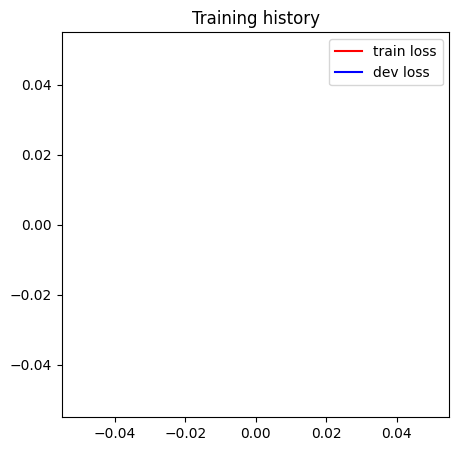

In [ ]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b', label='dev loss')
plt.legend()
plt.title('Training history')
plt.show()

In [ ]:
from torchmetrics import PearsonCorrCoef

In [ ]:
pearson = PearsonCorrCoef()
pearson(all_info['round_1']["client_plane_0"]['conv1']["weight"].data.reshape([1,-1]), all_info['round_1']["client_plane_0"]['conv1']["weight"].data.reshape([1,-1]))

ValueError: ignored

In [ ]:
all_info['round_1']["client_plane_0"]['conv1']["weight"].data.reshape([2,-1])

tensor([[-0.5085,  0.5274, -0.5161,  0.3827,  0.3365,  0.3572],
        [ 0.3950,  0.2911, -0.0009,  0.3895, -0.5123,  0.1007]])

In [ ]:
all_info['round_1']

{'client_0': None,
 'client_1': None,
 'client_2': None,
 'client_plane_0': {'conv1': {'weight': tensor([[[[-0.5085]],
   
            [[ 0.5274]],
   
            [[-0.5161]]],
   
   
           [[[ 0.3827]],
   
            [[ 0.3365]],
   
            [[ 0.3572]]],
   
   
           [[[ 0.3950]],
   
            [[ 0.2911]],
   
            [[-0.0009]]],
   
   
           [[[ 0.3895]],
   
            [[-0.5123]],
   
            [[ 0.1007]]]]),
   'bias': tensor([-0.1761,  0.4845,  0.5836, -0.4870])},
  'linear': {'weight': tensor([[ 0.0300, -0.0093, -0.0029,  ...,  0.0215,  0.0373,  0.0464],
           [-0.0293, -0.0171,  0.0150,  ...,  0.0081, -0.0166,  0.0053],
           [ 0.0154,  0.0055, -0.0276,  ..., -0.0328, -0.0030,  0.0019],
           ...,
           [ 0.0180,  0.0151, -0.0065,  ...,  0.0239, -0.0151,  0.0025],
           [-0.0185, -0.0054,  0.0165,  ..., -0.0240, -0.0168,  0.0261],
           [-0.0221,  0.0074, -0.0148,  ..., -0.0174,  0.0116, -0.0129]]),
   'bias':